In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
import numpyro.infer.kernels as kernels
from numpyro.callbacks import Progbar
from numpyro.distributions import NormalMixture
from numpyro.infer import ELBO, Stein, SVI
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer.initialization import init_with_noise, init_to_value

In [2]:
rng_key = jax.random.PRNGKey(42)
num_iterations = 1500

In [3]:
def model():
    numpyro.sample('x', NormalMixture(jnp.array([1/3, 2/3]), 
                                      jnp.array([-2., 2.]), jnp.array([1., 1.])))

In [4]:
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': -10.}), noise_scale=1.0))
svi = SVI(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO())
state, loss = svi.train(rng_key, num_iterations, callbacks=[Progbar()])
print(svi.get_params(state)['auto_x'])

SVI 2.0169: 100%|██████████| 1500/1500 [00:00<00:00, 2251.82it/s]


-1.9972894


In [5]:
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': -10.}), noise_scale=1.0))
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
             kernels.RBFKernel(), num_particles=100)
svgd_state = svgd.init(rng_key)

<AxesSubplot:ylabel='Density'>

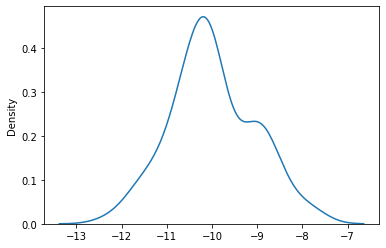

In [6]:
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'])


In [7]:
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])

Stein 2.0373: 100%|██████████| 1500/1500 [00:05<00:00, 254.24it/s]


<AxesSubplot:ylabel='Density'>

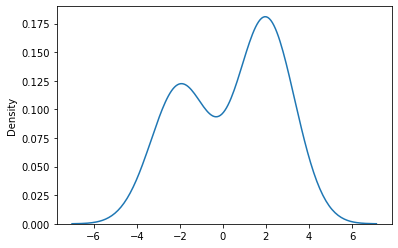

In [8]:
plt.clf()
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'])

In [9]:
svgd.get_params(svgd_state)['auto_x']

DeviceArray([-0.86947066, -4.3659105 , -0.4574525 ,  2.2992258 ,
              3.293306  ,  1.6895198 ,  1.4897382 ,  2.5170877 ,
             -1.6901796 ,  1.9044294 , -3.4782045 ,  0.68283635,
              0.51221645,  1.4976381 ,  3.7126782 ,  1.97584   ,
              1.7116706 , -2.3914409 , -1.9310573 ,  2.2438433 ,
              3.312945  ,  1.4700058 ,  0.21077457, -3.6922486 ,
             -2.3373666 ,  1.0941417 ,  3.6913593 , -2.2453058 ,
             -1.9521168 , -2.4637134 ,  2.3347645 ,  1.6678113 ,
              2.266918  ,  2.2891562 ,  1.5881422 ,  3.151615  ,
              3.0622876 ,  1.4021671 , -0.989298  ,  2.9231791 ,
             -0.9589464 , -2.3130748 , -2.266838  ,  0.1087871 ,
              3.3469703 , -1.5272444 ,  2.452323  ,  1.3449831 ,
             -2.4516952 , -0.8155817 , -1.5002838 ,  2.2998214 ,
             -1.8145167 , -3.1756163 , -2.3828754 , -1.5508174 ,
             -2.8551123 ,  0.8301426 , -2.5025163 , -1.9609264 ,
             -1.1482692 ,

In [10]:
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': -10.}), noise_scale=1.0))
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
             kernels.LinearKernel(), num_particles=100)
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])

Stein 2.2589: 100%|██████████| 1500/1500 [00:01<00:00, 1081.63it/s]


<AxesSubplot:ylabel='Density'>

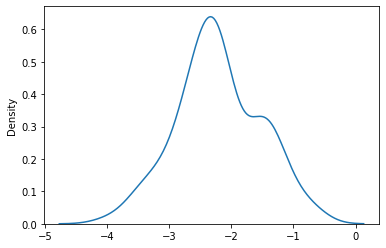

In [11]:
plt.clf()
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'])

In [12]:
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': -10.}), noise_scale=1.0))
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
             kernels.RandomFeatureKernel(), num_particles=100)
svgd_state, loss = svgd.train(rng_key, num_iterations * 2, callbacks=[Progbar()])

Stein 2.1156: 100%|██████████| 3000/3000 [00:25<00:00, 119.28it/s]


<AxesSubplot:ylabel='Density'>

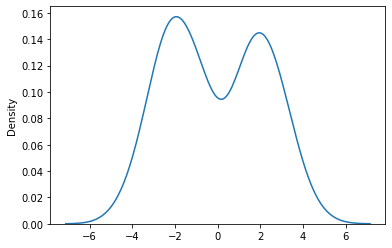

In [13]:
plt.clf()
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'])

In [14]:
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': -10.}), noise_scale=1.0))
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
             kernels.IMQKernel(), num_particles=100)
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])

Stein 2.1141: 100%|██████████| 1500/1500 [00:01<00:00, 918.41it/s]


<AxesSubplot:ylabel='Density'>

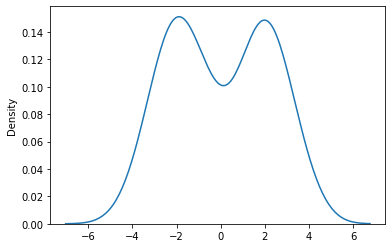

In [15]:
plt.clf()
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'])

In [16]:
guide = AutoDelta(model, init_strategy=init_with_noise(init_to_value(values={'x': -10.}), noise_scale=1.0))
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
             kernels.MixtureKernel([0.5, 0.5], [kernels.LinearKernel(), kernels.RandomFeatureKernel()]),
             num_particles=100)
svgd_state, loss = svgd.train(rng_key, num_iterations, callbacks=[Progbar()])

Stein 2.3088: 100%|██████████| 1500/1500 [00:16<00:00, 90.91it/s] 


<AxesSubplot:ylabel='Density'>

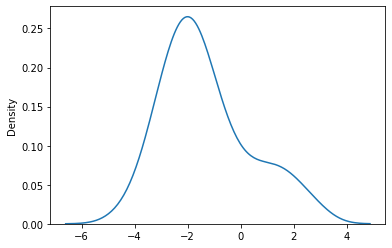

In [17]:
plt.clf()
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'])